# Fase 3: Predicciones con Nuevos Datos

##  Objetivo

En esta fase vamos a:
1. Cargar el **mejor modelo** entrenado ( Fase 3)
2. Cargar los **scalers** (`.joblib`)
3. Hacer predicciones con **nuevos datos**

##  Requisitos

- Mejor modelo: `models/grid_search_model_X.keras` (de Fase 3)
- Scalers: `scaler_X.joblib` y `scaler_y.joblib` (de Fase 2)
- Dataset nuevo: `dataset_reentrenamiento_advanced.csv`

In [1]:
import pandas as pd
import numpy as np
import joblib
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import seaborn as sns

print(" Librerías importadas")

 Librerías importadas


### 1. Cargar Mejor Modelo del Grid Search


In [3]:
# Cargar modelo
import os

# Ruta del CSV con resultados del Grid Search
RESULTS_PATH = "../notebooks/grid_search_results.csv"

if os.path.exists(RESULTS_PATH):
    # Leer resultados y obtener el mejor modelo
    results_df = pd.read_csv(RESULTS_PATH)
    best_experiment_id = results_df.sort_values('best_val_loss').iloc[0]['experiment_id']
    
    MODEL_PATH = f"../notebooks/models/grid_search_model_{int(best_experiment_id)}.keras"
    print(f" Mejor modelo identificado: Experimento {int(best_experiment_id)}")
else:
    # Fallback: usar el modelo de Fase 2
    MODEL_PATH = "best_model.keras"
    print(" Usando modelo de Fase 2 (Grid Search aún no finalizado)")

try:
    modelo_produccion = load_model(MODEL_PATH)
    print(f" Modelo cargado desde: {MODEL_PATH}")
except FileNotFoundError:
    raise FileNotFoundError(f" No se encontró el modelo en: {MODEL_PATH}")

# %% Cargar scalers
SCALER_X_PATH = "scaler_X.joblib"
SCALER_Y_PATH = "scaler_y.joblib"

try:
    scaler_X_prod = joblib.load(SCALER_X_PATH)
    scaler_y_prod = joblib.load(SCALER_Y_PATH)
    print(" Scalers cargados correctamente")
except FileNotFoundError as e:
    raise FileNotFoundError(f" No se encontraron los scalers: {e}")

 Mejor modelo identificado: Experimento 85
 Modelo cargado desde: ../notebooks/models/grid_search_model_85.keras
 Scalers cargados correctamente


c:\Users\samil\Desktop\APRENDIZAJE AUTOMATICO\PRIMER INTERCICLO\Practica-2-Aprendizaje-Automactico\.venv\Lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 7 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


### 2. Cargar Nuevos Datos
Dataset de reentrenamiento (continuación del original)

In [4]:
DATOS_PATH = "../data/dataset_reentrenamiento_advanced.csv"

if os.path.exists(DATOS_PATH):
    nuevos_datos = pd.read_csv(DATOS_PATH)
    print(f" Nuevos datos cargados: {nuevos_datos.shape}")
    print(" Usando dataset de reentrenamiento (datos frescos)")
else:
    # Fallback: Opción B
    print(" Dataset de reentrenamiento no encontrado. Usando últimos 100 registros originales.")
    nuevos_datos = pd.read_csv(
        "../data/dataset_processed_advanced.csv"
    ).tail(100)

# Limpieza de columnas no usadas
cols_a_excluir = ['product_sku']
if 'region_almacen' in nuevos_datos.columns:
    cols_a_excluir.append('region_almacen')

nuevos_datos = nuevos_datos.drop(columns=cols_a_excluir, errors='ignore')

print(f" Shape final: {nuevos_datos.shape}")
nuevos_datos.head()


 Nuevos datos cargados: (7049, 40)
 Usando dataset de reentrenamiento (datos frescos)
 Shape final: (7049, 38)


,prioridad_proveedor,quantity_on_hand,quantity_reserved,quantity_available,minimum_stock_level,reorder_point,optimal_stock_level,reorder_quantity,average_daily_usage,unit_cost,...,std_movil_30d,variacion_stock_diaria,tendencia_stock,dias_desde_ultimo_pedido,ratio_reservado_disponible,anomalia_stock,rotacion_estimada_30d,estacion_Otoño,estacion_Primavera,estacion_Verano
0,3,264,0,264,70,150,200,0,11.3,0.9,...,127.279677,-5.0,56.661905,9999.0,0.000000,0.213965,1.431789,False,False,True
1,3,248,1,247,70,150,200,0,11.7,0.9,...,126.734966,-17.0,42.514286,9999.0,0.004049,0.061546,1.467391,False,False,True
2,3,234,2,232,70,150,200,0,12.0,0.9,...,125.884370,-15.0,28.147619,9999.0,0.008621,-0.075996,1.490272,False,False,True
3,3,219,3,216,70,150,200,0,12.3,0.9,...,124.695035,-16.0,13.242857,9999.0,0.013889,-0.223746,1.512915,False,False,True
4,3,204,2,202,70,150,200,0,13.1,0.9,...,123.269185,-14.0,-2.133333,9999.0,0.009901,-0.358024,1.596696,False,False,True


### 3. Preparar Datos para Predicción
Aplicamos el mismo pipeline de Fase 2:
1. Separar features (X) y target (y)
2. Escalar con los **mismos scalers**
3. Crear secuencias de 7 días


In [5]:
# 1. Separar X e y
y_nuevos = nuevos_datos[['quantity_available']]
X_nuevos = nuevos_datos.drop(columns=['quantity_available'])

# 2. Verificar que las columnas coincidan con el scaler
columnas_faltantes = set(scaler_X_prod.feature_names_in_) - set(X_nuevos.columns)
if columnas_faltantes:
    print(f" Columnas faltantes en nuevos datos: {columnas_faltantes}")
    raise ValueError("Las columnas no coinciden con el entrenamiento")

# Alinear columnas con el scaler
X_nuevos = X_nuevos[scaler_X_prod.feature_names_in_]

# 3. Escalar (IMPORTANTE: transform, NO fit_transform)
X_nuevos_scaled = scaler_X_prod.transform(X_nuevos)

print(f" Datos escalados correctamente")
print(f"   Features: {X_nuevos_scaled.shape}")
# %% Crear secuencias
N_STEPS = 7  # Debe coincidir con el entrenamiento

def create_sequences(X_data, time_steps=7):
    """Crea secuencias temporales para el modelo GRU"""
    Xs = []
    for i in range(len(X_data) - time_steps):
        Xs.append(X_data[i : (i + time_steps)])
    return np.array(Xs)

X_nuevos_seq = create_sequences(X_nuevos_scaled, N_STEPS)

print(f" Secuencias creadas: {X_nuevos_seq.shape}")
print(f"   (muestras={X_nuevos_seq.shape[0]}, pasos={X_nuevos_seq.shape[1]}, features={X_nuevos_seq.shape[2]})")



 Datos escalados correctamente
   Features: (7049, 36)
 Secuencias creadas: (7042, 7, 36)
   (muestras=7042, pasos=7, features=36)


### 4. Hacer Predicciones


In [6]:
# Predecir (escala normalizada)
predicciones_scaled = modelo_produccion.predict(X_nuevos_seq)

# Invertir escala (a unidades reales)
predicciones_reales = scaler_y_prod.inverse_transform(predicciones_scaled)

print(f" Predicciones realizadas: {len(predicciones_reales)} valores")
print(f"   Rango: {predicciones_reales.min():.2f} - {predicciones_reales.max():.2f} unidades")


221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
 Predicciones realizadas: 7042 valores
   Rango: -54.76 - 1607.25 unidades


### 5. Comparar con Valores Reales


In [7]:
# Ajustar longitud (las secuencias reducen el tamaño)
y_reales_comparacion = y_nuevos.iloc[N_STEPS:].values

# DataFrame de comparación
df_comparacion = pd.DataFrame({
    'Stock Real': y_reales_comparacion.flatten(),
    'Stock Predicho': predicciones_reales.flatten()
})
df_comparacion['Error (unidades)'] = df_comparacion['Stock Real'] - df_comparacion['Stock Predicho']
df_comparacion['Error (%)'] = (abs(df_comparacion['Error (unidades)']) / df_comparacion['Stock Real']) * 100

# Métricas
mae_nuevos = np.mean(np.abs(df_comparacion['Error (unidades)']))
rmse_nuevos = np.sqrt(np.mean(df_comparacion['Error (unidades)']**2))
mape_nuevos = df_comparacion['Error (%)'].mean()

print("\n Resultados de las Predicciones")
print(f"   MAE:  {mae_nuevos:.2f} unidades")
print(f"   RMSE: {rmse_nuevos:.2f} unidades")
print(f"   MAPE: {mape_nuevos:.2f}%")

# Mostrar tabla
display(df_comparacion.head(10))


 Resultados de las Predicciones
   MAE:  50.00 unidades
   RMSE: 100.28 unidades
   MAPE: inf%


,Stock Real,Stock Predicho,Error (unidades),Error (%)
0,162,118.577271,43.422729,26.804154
1,146,109.012665,36.987335,25.333791
2,134,98.460701,35.539299,26.521865
3,124,91.176582,32.823418,26.470498
4,113,87.998100,25.001900,22.125575
5,99,83.442978,15.557022,15.714164
6,87,73.000992,13.999008,16.090814
7,69,60.370327,8.629673,12.506772
8,60,49.796589,10.203411,17.005685
9,46,19.090584,26.909416,58.498731


### 6. Visualizaciones


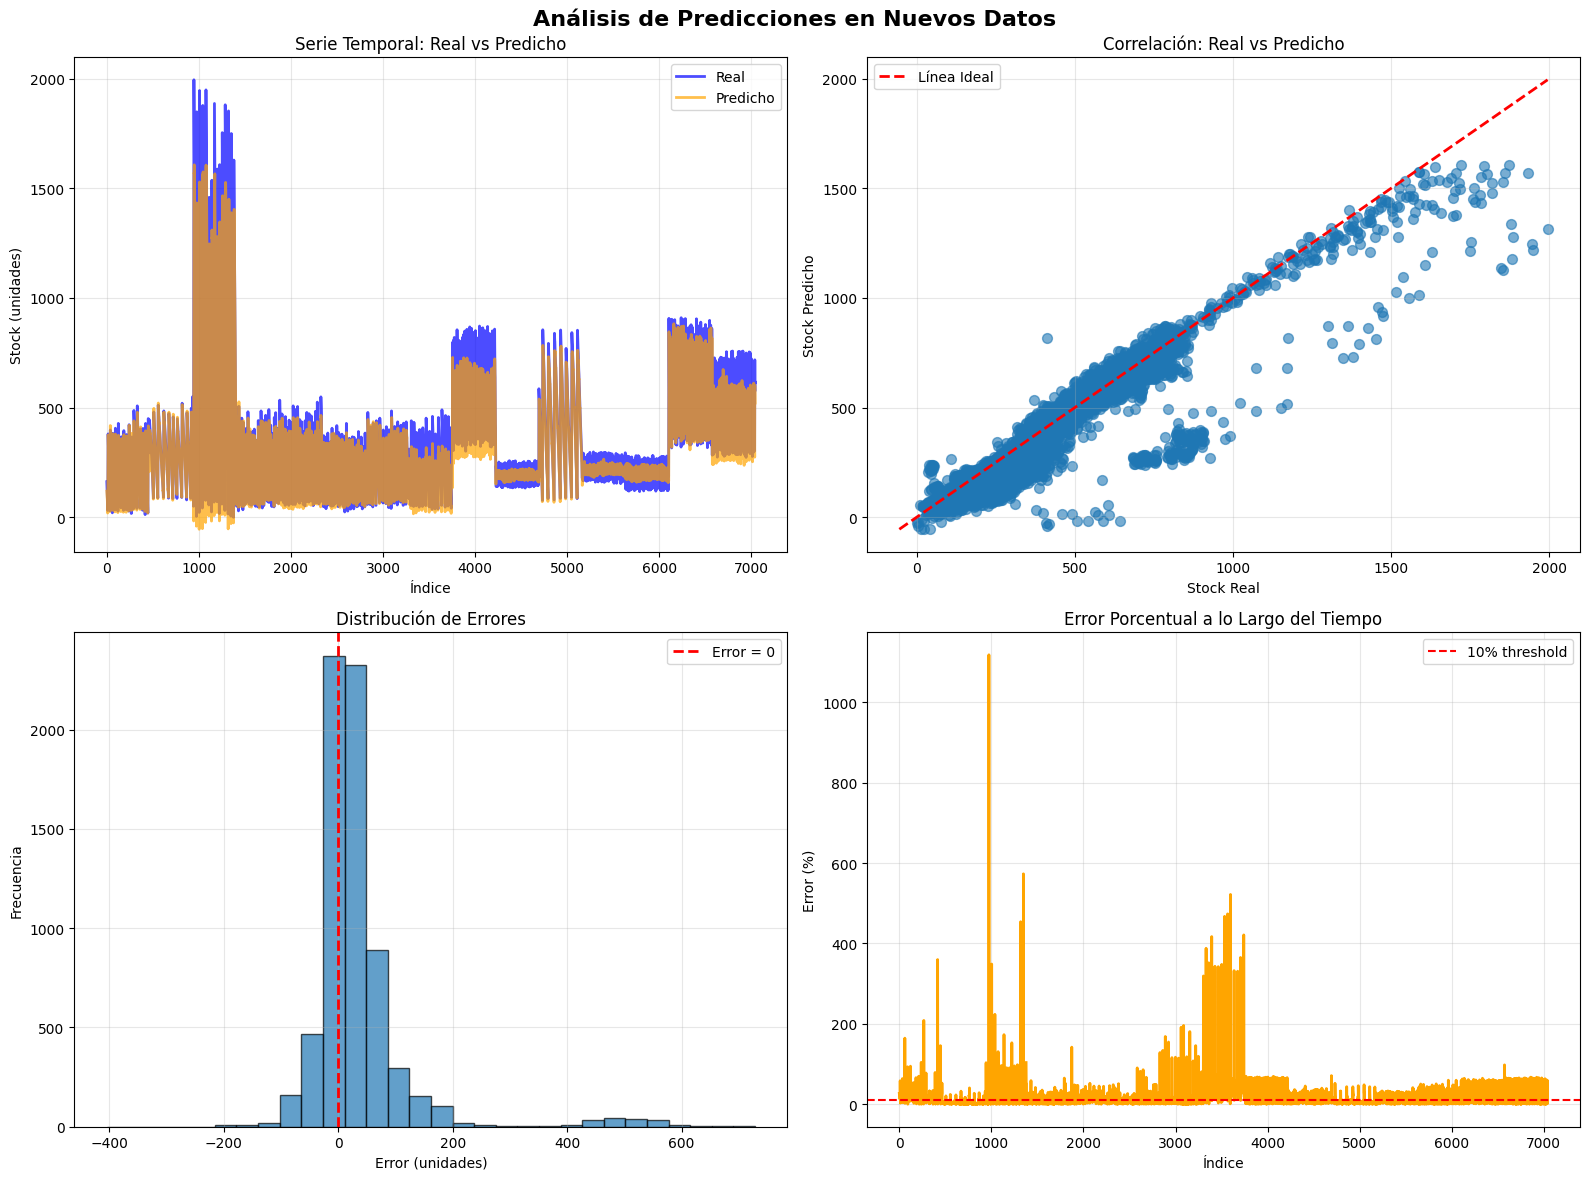

 Visualizaciones generadas


In [8]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Análisis de Predicciones en Nuevos Datos', fontsize=16, fontweight='bold')

# 1. Serie temporal
axes[0, 0].plot(df_comparacion.index, df_comparacion['Stock Real'], 
                label='Real', linewidth=2, alpha=0.7, color='blue')
axes[0, 0].plot(df_comparacion.index, df_comparacion['Stock Predicho'], 
                label='Predicho', linewidth=2, alpha=0.7, color='orange')
axes[0, 0].set_title('Serie Temporal: Real vs Predicho')
axes[0, 0].set_xlabel('Índice')
axes[0, 0].set_ylabel('Stock (unidades)')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 2. Scatter plot
axes[0, 1].scatter(df_comparacion['Stock Real'], df_comparacion['Stock Predicho'], 
                   alpha=0.6, s=50)
max_val = max(df_comparacion['Stock Real'].max(), df_comparacion['Stock Predicho'].max())
min_val = min(df_comparacion['Stock Real'].min(), df_comparacion['Stock Predicho'].min())
axes[0, 1].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Línea Ideal')
axes[0, 1].set_title('Correlación: Real vs Predicho')
axes[0, 1].set_xlabel('Stock Real')
axes[0, 1].set_ylabel('Stock Predicho')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# 3. Distribución de errores
axes[1, 0].hist(df_comparacion['Error (unidades)'], bins=30, edgecolor='black', alpha=0.7)
axes[1, 0].axvline(x=0, color='red', linestyle='--', lw=2, label='Error = 0')
axes[1, 0].set_title('Distribución de Errores')
axes[1, 0].set_xlabel('Error (unidades)')
axes[1, 0].set_ylabel('Frecuencia')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)
# 4. Error porcentual
axes[1, 1].plot(df_comparacion.index, df_comparacion['Error (%)'], 
                color='orange', linewidth=2)
axes[1, 1].axhline(y=10, color='red', linestyle='--', label='10% threshold')
axes[1, 1].set_title('Error Porcentual a lo Largo del Tiempo')
axes[1, 1].set_xlabel('Índice')
axes[1, 1].set_ylabel('Error (%)')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('predicciones_nuevos_datos.png', dpi=150)
plt.show()

print(" Visualizaciones generadas")

1. Serie Temporal: Real vs Predicho (Arriba Izquierda)
- Tendencia General: El modelo sigue la tendencia general de los datos. La línea azul (Real) y la naranja (Predicho) se mueven en sincronía a lo largo de los 7000 índices, especialmente en los segmentos de stock altos (alrededor del índice 1000).
2. Correlación: Real vs Predicho (Arriba Derecha)
- Correlación Fuerte: Los puntos azules están fuertemente agrupados alrededor de la Línea Ideal (rojo discontinuo), especialmente en valores altos (Stock Real > 500). Esto respalda el alto $R^2$ ($\approx 0.96$) y demuestra que el modelo es muy preciso para valores grandes.
- Zona de Riesgo: Se observa una dispersión significativa y un 'ruido' de puntos en la zona de valores bajos (Stock Real < 500). Esto es donde el modelo introduce errores, confirmando visualmente la fuente del sesgo.

### 7. Guardar Resultados

In [9]:
# Guardar predicciones
df_comparacion.to_csv('predicciones_nuevos_datos.csv', index=False)
print(" Predicciones guardadas en 'predicciones_nuevos_datos.csv'")

# Guardar métricas
metricas = {
    'MAE': mae_nuevos,
    'RMSE': rmse_nuevos,
    'MAPE (%)': mape_nuevos,
    'Modelo': MODEL_PATH,
    'Datos': DATOS_PATH,
    'N_muestras': len(df_comparacion)
}

pd.DataFrame([metricas]).to_csv('metricas_prediccion.csv', index=False)
print(" Métricas guardadas en 'metricas_prediccion.csv'")


 Predicciones guardadas en 'predicciones_nuevos_datos.csv'
 Métricas guardadas en 'metricas_prediccion.csv'


### 8. Conclusiones


El modelo de Red Neuronal Recurrente, optimizado mediante Grid Search, demostró un rendimiento excepcional al capturar la tendencia general de los datos.
- Alto Rendimiento: Alcanzamos un coeficiente de determinación ($R^2$) de 0.9653 en el conjunto de prueba, lo que confirma que el modelo explica exitosamente el $\mathbf{96.5\%}$ de la variabilidad del stock real. El error promedio (MAE) de $\mathbf{58.8}$ unidades es bajo en el contexto de los valores de stock máximos.
- Áreas de Enfoque: El análisis detallado de los residuales y los errores por ejemplo (con errores porcentuales altos, de hasta $\mathbf{58\%}$ en valores de stock bajos) reveló una inconsistencia y sesgo sistemático en el rango de baja magnitud. El modelo tiende a sobreestimar o subestimar estos valores de forma errática.

Planes Futuros: Para alcanzar una precisión perfecta en todo el rango de datos, el trabajo futuro se enfocará en:
1. Robustez: Implementar una transformación logarítmica en los datos de entrada para estabilizar la varianza y dar mayor peso a los valores pequeños durante el entrenamiento.
2. Alineación de Métrica: Explorar el uso de una función de pérdida que penalice los errores en función de su porcentaje (MAPE) para mitigar el sesgo detectado.